# M-estimation of stochastic action plans
Generally, we are interested in the estimation of deterministic action plans. For example, we may want to estimate the mean of an outcome with everyone under action $a=1$. Using potential outcomes, this quantity is
$$E[Y(a=1)]$$
where $Y(a)$ is the potential outcome under action $a$ (and observations are assumed to be IID).

A competing estimand is the outcome mean under a stochastic plan. Namely, the stochastic plan sets the *probability* of an action for each individual. We denote this investigator-specified probability by $\Pr^*(A=1 | W)$, where $A$ is the action and $W$ is baseline covariates. The stochastic mean can be denoted as
$$E[Y(a=1) \Pr^*(A=1 | W)]$$
Notice the deterministic plan is a special case of a stochastic plan, where $\Pr^*(A=1 | W) = 1$ (and reduces to the previous). 

A variety of $\Pr^*(A=1 | W)$ functions can be specified. One general example is to set the probability to a constant, $\Pr^*(A=1 | W) = \alpha$. For example, $\alpha = 0.5$ would correspond to the mean had everyone given given a 50% chance of $a=1$. This type of investigator-specified function could further be made to change based on the baseline covariates $W$. 

Perhaps a more realistic alternative (or rather a investigator function more amenable to actual implementation) are shifts in an individual's probability of an action. If $\Pr(A=1 | W)$ denotes the population conditional probability of  an action, then we can consider the policy
$$\Pr^*(A=1 | W) = \text{logit}(\Pr(A=1 | W) + \delta)$$
where $\delta$ indicates a shift in the log-odds of the action. Therefore, this plan can be viewed as an intervention which increases (or decreases for $\delta < 0$) the uptake of action $a=1$. Hereafter, our tutorial focuses on this latter parameter. 

To estimate the mean under our stochastic plan, we use the following inverse probability weighting estimator
$$\mu_{IPW} = \sum_{i=1}^n Y_i \frac{\Pr^*(A_i=1|W_i)}{\Pr(A_i=1 | W_i)}$$


## Overview
Here, we demonstrate how M-estimation can be used to estimate the mean under stochastic action plans. Specifically, we demonstrate plans where the probability of $A=1$ is shifted, which involves estimation of the conditional probability of $A=1$. We discuss a the pitfall: estimation of the probability to be shifted is treated as known. We show how M-estimation (and the sandwich variance) can easily accomodate this feature.

In [1]:
# Initial setup
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import delicatessen
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_logistic_regression 
from delicatessen.estimating_equations import ee_ridge_linear_regression
from delicatessen.utilities import inverse_logit

np.random.seed(51520837)

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Delicatessen version:", delicatessen.__version__)

NumPy version:        1.19.5
SciPy version:        1.5.4
Pandas version:       1.1.5
Delicatessen version: 0.2


## Motivating Problem
To motivate our discussion, we will consider data generated according to the following diagram. 

<AxesSubplot:>

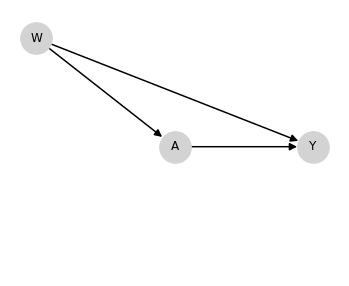

In [2]:
from zepid.causal.causalgraph import DirectedAcyclicGraph
from zepid.graphics import pvalue_plot

dag = DirectedAcyclicGraph(exposure="A", outcome="Y")
dag.add_arrows(pairs=(("A", "Y"), 
                      ("W", "Y"), ("W", "A")))
pos = {"A": [0, 0], "Y": [1, 0], "W": [-1, 0.01]}
dag.draw_dag(positions=pos)

The following generates 1000 observations that adhere to the causal diagram

In [3]:
n = 1000  # Generating lots of observations to reduce randomness

# Generating baseline covariates
d = pd.DataFrame()
d['W'] = np.random.normal(size=n)

# Generating actions
pr_a = sp.stats.logistic.cdf(0. + 0.9*d['W'])
d['A'] = np.random.binomial(n=1, p=pr_a,
                            size=n)

# Generating potential outcomes
d['Ya1'] = (25 + 2 - 2.5*d['W'] 
            + 1.6*1*d['W']
            + np.random.normal(size=n))
d['Ya0'] = (25 + 0 - 2.5*d['W'] 
            + 1.6*0*d['W']
            + np.random.normal(size=n))
# Generating outcomes via causal consistency
d['Y'] = np.where(d['A'] == 1, d['Ya1'], d['Ya0'])

# Data we get to see
d = d[["W", "A", "Y"]].copy()
d['C'] = 1
d.describe()

,W,A,Y,C
count,1000.000000,1000.00000,1000.000000,1000.0
mean,0.001030,0.50000,26.240595,1.0
std,0.981461,0.50025,2.053081,0.0
min,-3.748238,0.00000,17.445751,1.0
25%,-0.657874,0.00000,25.099512,1.0
50%,-0.004908,0.50000,26.373613,1.0
75%,0.659594,1.00000,27.453567,1.0
max,2.757382,1.00000,34.671126,1.0


# Estimation
Here, we estimate the probability of $A$. Those probabilities are then shifted according to our policy (plus 1.5 to the log-odds of $A$). The shifted probability is treated an being estimated in this M-estimator (since the coefficients for the model are all being estimated inside the `psi` function).

In [4]:
# Extracting covariates for use in psi()
W = np.asarray(d[['C', 'W']])
A = np.asarray(d['A'])
y = np.asarray(d['Y'])

delta = 1.5


def psi(theta):
    beta = theta[1:]
    
    # Estimating Pr(A=1|W=w) for weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    logit_pi_aw = np.dot(W, beta)
    
    # Constructing denominator of weights
    pi_a = inverse_logit(logit_pi_aw)
    
    # Constructing numerator of weights
    pi_a_delta = inverse_logit(logit_pi_aw + delta)
    
    # Creating IPW
    ipw = np.where(A==1, pi_a_delta/pi_a, (1-pi_a_delta)/(1-pi_a))

    # Calculating mean at stochastic policy
    ya_delta = y*ipw - theta[0]
    
    # Returning estimating equations
    return np.vstack((ya_delta[None, :],
                      a_model))


# Estimating equation
starting_vals = [0, 0, 0]
estr1 = MEstimator(psi, init=starting_vals)
estr1.estimate(solver='lm')

mean = estr1.theta[0]
var = estr1.variance[0, 0]
ci = estr1.confidence_intervals()[0, :]

print("======================================")
print("Accounting for Confounding")
print("======================================")
print("ACE:   ", np.round(mean, 3))
print("95% CI:", np.round(ci, 3))
print("======================================")

Accounting for Confounding
ACE:    26.765
95% CI: [26.642 26.888]


This second M-estimator treats the probabilities being shifted as *known*. This can be seen by the coefficients used to construct `pi_a_delta` being estimated outside of the `psi` function (the coefficients are pulled from the previous model). Therefore, this M-estimator (incorrectly) assumes that the stochastic plan is *known*.

In [5]:
# Extracting covariates for use in psi()
W = np.asarray(d[['C', 'W']])
A = np.asarray(d['A'])
y = np.asarray(d['Y'])

# previous coefficients
coefs = estr1.theta[1:]
delta = 1.5


def psi(theta):
    beta = theta[1:]
    
    # Estimating Pr(A=1|W=w) and weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    logit_pi_aw = np.dot(W, beta)
    
    # Constructing denominator of weights
    pi_a = inverse_logit(logit_pi_aw)
    
    # Constructing numerator of weights
    pi_a_delta = inverse_logit(np.dot(W, coefs) + delta)
    
    # Creating IPW
    ipw = np.where(A==1, pi_a_delta/pi_a, (1-pi_a_delta)/(1-pi_a))

    # Calculating ACE
    ya_delta = y*ipw - theta[0]
    return np.vstack((ya_delta[None, :],
                      a_model))

starting_vals = [0, 0, 0]
estr2 = MEstimator(psi, init=starting_vals)
estr2.estimate(solver='lm')

mean2 = estr2.theta[0]
var2 = estr2.variance[0, 0]
ci2 = estr2.confidence_intervals()[0, :]

print("======================================")
print("Accounting for Confounding")
print("======================================")
print("ACE:   ", np.round(mean2, 3))
print("95% CI:", np.round(ci2, 3))
print("======================================")

Accounting for Confounding
ACE:    26.765
95% CI: [26.648 26.882]


While not extreme in this example, we can see that the confidence interval difference is smaller for the latter estimator. Ignoring the fact that we need to estimate pieces of the stochastic plan leads to a false sense of greater precision. The first estimator is what should be used here.

## Simulation study
To better explore the difference between these two competing estimators, below is a simple simulation study. We will compare bias (no difference expected) and confidence interval coverage (the latter estimator may have below expected confidence interval coverage). We evaluate for a variety of values: $-5 \le \delta \le 5$.

In [6]:
def dgm_true(delta):
    n = 1000000
    d = pd.DataFrame()
    d['W'] = np.random.normal(size=n)
    pr_a = sp.stats.logistic.cdf(0. + 0.9*d['W'] + delta)
    d['A'] = np.random.binomial(n=1, p=pr_a,
                                size=n)
    d['Ya1'] = (25 + 2 - 2.5*d['W'] 
                + 1.6*1*d['W']
                + np.random.normal(size=n))
    d['Ya0'] = (25 + 0 - 2.5*d['W'] 
                + 1.6*0*d['W']
                + np.random.normal(size=n))
    d['Y'] = np.where(d['A'] == 1, d['Ya1'], d['Ya0'])
    return np.mean(d['Y'])


def dgm(n):
    d = pd.DataFrame()
    d['W'] = np.random.normal(size=n)
    pr_a = sp.stats.logistic.cdf(0. + 0.9*d['W'])
    d['A'] = np.random.binomial(n=1, p=pr_a,
                                size=n)
    d['Ya1'] = (25 + 2 - 2.5*d['W'] 
                + 1.6*1*d['W']
                + np.random.normal(size=n))
    d['Ya0'] = (25 + 0 - 2.5*d['W'] 
                + 1.6*0*d['W']
                + np.random.normal(size=n))
    d['Y'] = np.where(d['A'] == 1, d['Ya1'], d['Ya0'])
    d['C'] = 1
    return d[["W", "A", "C", "Y"]]


def psi_estr1(theta, delta, W, A, y):
    beta = theta[1:]

    # Estimating Pr(A=1|W=w) for weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    logit_pi_aw = np.dot(W, beta)

    # Constructing denominator of weights
    pi_a = inverse_logit(logit_pi_aw)

    # Constructing numerator of weights
    pi_a_delta = inverse_logit(logit_pi_aw + delta)

    # Creating IPW
    ipw = np.where(A==1, pi_a_delta/pi_a, (1-pi_a_delta)/(1-pi_a))

    # Calculating mean at stochastic policy
    ya_delta = y*ipw - theta[0]

    # Returning estimating equations
    return np.vstack((ya_delta[None, :],
                      a_model))


def psi_estr2(theta, delta, W, A, y, coefs):
    beta = theta[1:]

    # Estimating Pr(A=1|W=w) for weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    logit_pi_aw = np.dot(W, beta)

    # Constructing denominator of weights
    pi_a = inverse_logit(logit_pi_aw)

    # Constructing numerator of weights
    pi_a_delta = inverse_logit(np.dot(W, coefs) + delta)

    # Creating IPW
    ipw = np.where(A==1, pi_a_delta/pi_a, (1-pi_a_delta)/(1-pi_a))

    # Calculating mean at stochastic policy
    ya_delta = y*ipw - theta[0]

    # Returning estimating equations
    return np.vstack((ya_delta[None, :],
                      a_model))

In [7]:
delta = np.linspace(-5, 5, 41)

truth = {}
est_estr1, est_estr2 = {}, {}
ci_estr1, ci_estr2 = {}, {}
for d in delta:
    truth[d] = dgm_true(delta=d)
    est_estr1[d], est_estr2[d] = [], []
    ci_estr1[d], ci_estr2[d] = [], []


# Ignoring any warnings in the sims (to keep output clean)
import warnings
warnings.filterwarnings("ignore")

In [8]:
for i in range(4000):
    data = dgm(n=1000)
    for d in delta:
        W = np.asarray(data[['C', 'W']])
        A = np.asarray(data['A'])
        y = np.asarray(data['Y'])
        
        # First option
        def psi(theta):
            return psi_estr1(theta=theta, delta=d,
                             W=W, A=A, y=y)

        starting_vals = [0, -0.1, 0.7]
        estr = MEstimator(psi, init=starting_vals)
        estr.estimate(solver='newton', maxiter=20000)
        est_estr1[d].append(estr.theta[0] - truth[d])
        ci = estr.confidence_intervals()[0, :]
        if ci[0] < truth[d] and ci[1] > truth[d]:
            ci_estr1[d].append(1)
        else:
            ci_estr1[d].append(0)

        # Second option
        # previously optimized coefs
        coefficients = estr.theta[1:]
        def psi(theta):
            return psi_estr2(theta=theta, delta=d,
                             W=W, A=A, y=y, coefs=coefficients)

        starting_vals = [0, -0.1, 0.7]
        estr = MEstimator(psi, init=starting_vals)
        estr.estimate(solver='newton', maxiter=20000)
        est_estr2[d].append(estr.theta[0] - truth[d])
        if ci[0] < truth[d] and ci[1] > truth[d]:
            ci_estr2[d].append(1)
        else:
            ci_estr2[d].append(0)


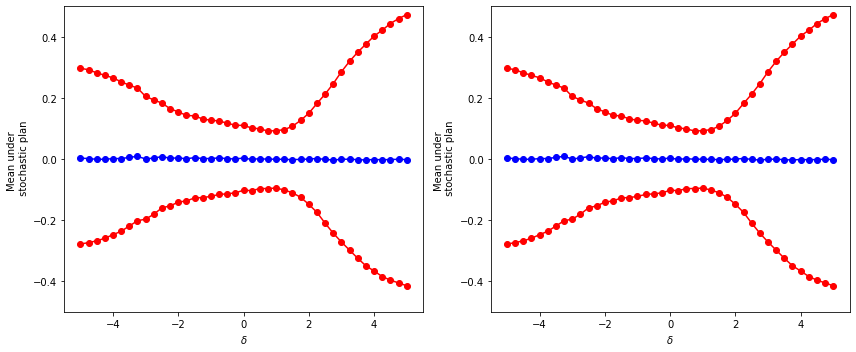

In [9]:
estr1_bias, estr2_bias = {}, {}
estr1_lower, estr2_lower = {}, {}
estr1_upper, estr2_upper = {}, {}
for d in delta:
    estr1_bias[d] = np.mean(est_estr1[d])
    estr2_bias[d] = np.mean(est_estr2[d])
    estr1_lower[d] = np.quantile(est_estr1[d], q=0.05)
    estr2_lower[d] = np.quantile(est_estr2[d], q=0.05)
    estr1_upper[d] = np.quantile(est_estr1[d], q=0.95)
    estr2_upper[d] = np.quantile(est_estr2[d], q=0.95)


plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.plot(estr1_bias.keys(), estr1_bias.values(), 'o-', color='blue')
plt.plot(estr1_lower.keys(), estr1_lower.values(), 'o-', color='red')
plt.plot(estr1_upper.keys(), estr1_upper.values(), 'o-', color='red')
plt.xlabel(r"$\delta$")
plt.ylabel("Mean under \n stochastic plan")
plt.ylim([-0.5, 0.5])

plt.subplot(122)
plt.plot(estr2_bias.keys(), estr2_bias.values(), 'o-', color='blue')
plt.plot(estr1_lower.keys(), estr1_lower.values(), 'o-', color='red')
plt.plot(estr1_upper.keys(), estr1_upper.values(), 'o-', color='red')
plt.xlabel(r"$\delta$")
plt.ylabel("Mean under \n stochastic plan")
plt.ylim([-0.5, 0.5])

plt.tight_layout()

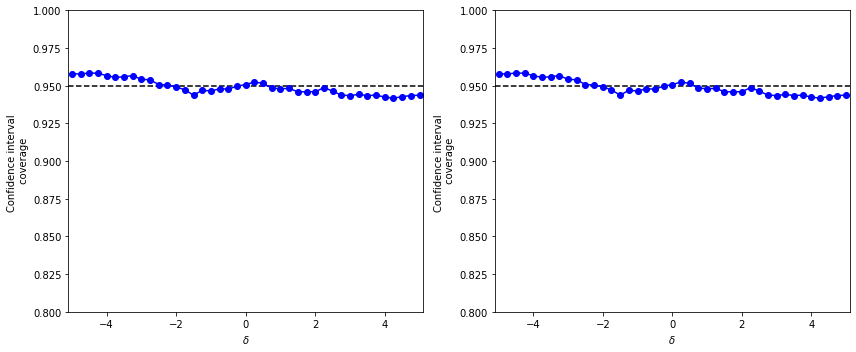

In [10]:
estr1_cover, estr2_cover = {}, {}
for d in delta:
    estr1_cover[d] = np.mean(ci_estr1[d])
    estr2_cover[d] = np.mean(ci_estr2[d])


plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.plot(estr1_cover.keys(), estr1_cover.values(), 'o-', color='blue')
plt.hlines(0.95, -5.1, 5.1, colors='k', linestyles='--')
plt.xlabel(r"$\delta$")
plt.ylabel("Confidence interval \n coverage")
plt.ylim([0.8, 1])
plt.xlim([-5.1, 5.1])

plt.subplot(122)
plt.plot(estr2_cover.keys(), estr2_cover.values(), 'o-', color='blue')
plt.hlines(0.95, -5.1, 5.1, colors='k', linestyles='--')
plt.xlabel(r"$\delta$")
plt.ylabel("Confidence interval \n coverage")
plt.ylim([0.8, 1])
plt.xlim([-5.1, 5.1])

plt.tight_layout()

As seen here, both approaches peform similarly in our simulation. While no difference was observed in our simulation, the first estimator is to be preferred on theoretical grounds (there may be cases where there is an important difference between the two and the latter estimator is expected to have poor confidence interval coverage in those cases).